In [3]:
from pathlib import Path

import os
import utm
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
from fluxdataqaqc import Data
from rasterio.plot import show

import sys
sys.path.append("../micromet/") 
import micromet.ffp as ffp

import utm
%matplotlib inline
__author__ = 'John Volk'

In [7]:
stat_data = Data('../station_config/US-UTW.ini')
stat_data.out_dir = Path('../station_config/output')
stat_data.variables['MO_LENGTH'] = 'MO_LENGTH'
stat_data.variables['USTAR'] = 'USTAR'
stat_data.variables['V_SIGMA'] = 'V_SIGMA'

df = stat_data.df.rename(columns=stat_data.inv_map)
df = df.resample('h').mean()

Calculating mean for var: THETA from columns: ['SWC_1_1_1', 'SWC_2_1_1']
Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
latitude = stat_data.latitude
longitude = stat_data.longitude
station_coord = (latitude, longitude)
# get EPSG code from lat,long, convert to UTM https://epsg.io/32617
#EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((-183+longitude)/6.0)
EPSG = 5070
#utm_coords = utm.from_latlon(latitude, longitude)

transformer = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG:.0f}")
(station_y, station_x) = transformer.transform(*station_coord)
station = stat_data.site_id
(station_y, station_x)

(-1251001.2763440341, 1921956.3381891234)

In [10]:
#Other model parameters
h_c = 0.2 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)

zm_s = 2. #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 200. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)

#Loop through each day in the dataframe
for date in df.index.date:
    
    #Subset dataframe to only values in day of year
    print(f'Date: {date}')
    temp_df = df[df.index.date == date]
        
    new_dat = None
    
    for indx,t in enumerate(hours):
        
        band = indx + 1
        print(f'Hour: {t}')

        try:
            temp_line = temp_df.loc[temp_df.index.hour == t,:]

            #Calculate footprint
            temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                    zm=zm_s-d, h=h_s, rs=None, z0=h_c*.123, 
                                    ol=temp_line['MO_LENGTH'].values,sigmav=temp_line['V_SIGMA'].values,
                                    ustar=temp_line['USTAR'].values, #umean=temp_line['ws'].values,
                                    wind_dir=temp_line['wd'].values,
                                    crop=0,fig=0,verbosity=0)
            ####verbosoity=2 prints out errors; if z0 triggers errors, use umean
            #    print(zm_s-d)

            f_2d = np.array(temp_ffp.output['fclim_2d'])
            x_2d = np.array(temp_ffp.output['x_2d']) + station_x
            y_2d = np.array(temp_ffp.output['y_2d']) + station_y
            f_2d = f_2d*dx**2

            #Calculate affine transform for given x_2d and y_2d
            affine_transform = ffp.find_transform(x_2d,y_2d)

            #Create data file if not already created
            if new_dat is None:
                out_f = f'../station_config/output/a{date}_{station}.tif'
                print(f_2d.shape)
                new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                                        count=len(hours),height=f_2d.shape[0],width=f_2d.shape[1],
                                        transform=affine_transform,
                                        crs=transformer.target_crs,
                                        nodata=0.00000000e+000)

        except Exception as e:

            print(f'Hour {t} footprint failed, band {band} not written.')
            print(e)
            temp_ffp = None

            continue

        #Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ffp.mask_fp_cutoff(f_2d)

        #Write the new band
        new_dat.write(f_2d,indx+1)

        #Update tags with metadata
        tag_dict = {'hour':f'{t*100:04}',
                    'wind_dir':temp_line['wd'].values,
                    'total_footprint':np.nansum(f_2d)}

        new_dat.update_tags(indx+1,**tag_dict)
    
    #Close dataset if it exists
    try:
        new_dat.close()
    except:
        continue
    
    print()
    
    # for esample just create a single day and exit
    break

Date: 2021-05-20
Hour: 7
Hour 7 footprint failed, band 1 not written.
operands could not be broadcast together with shapes (134,134) (0,) 
Hour: 8
(134, 134)
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20



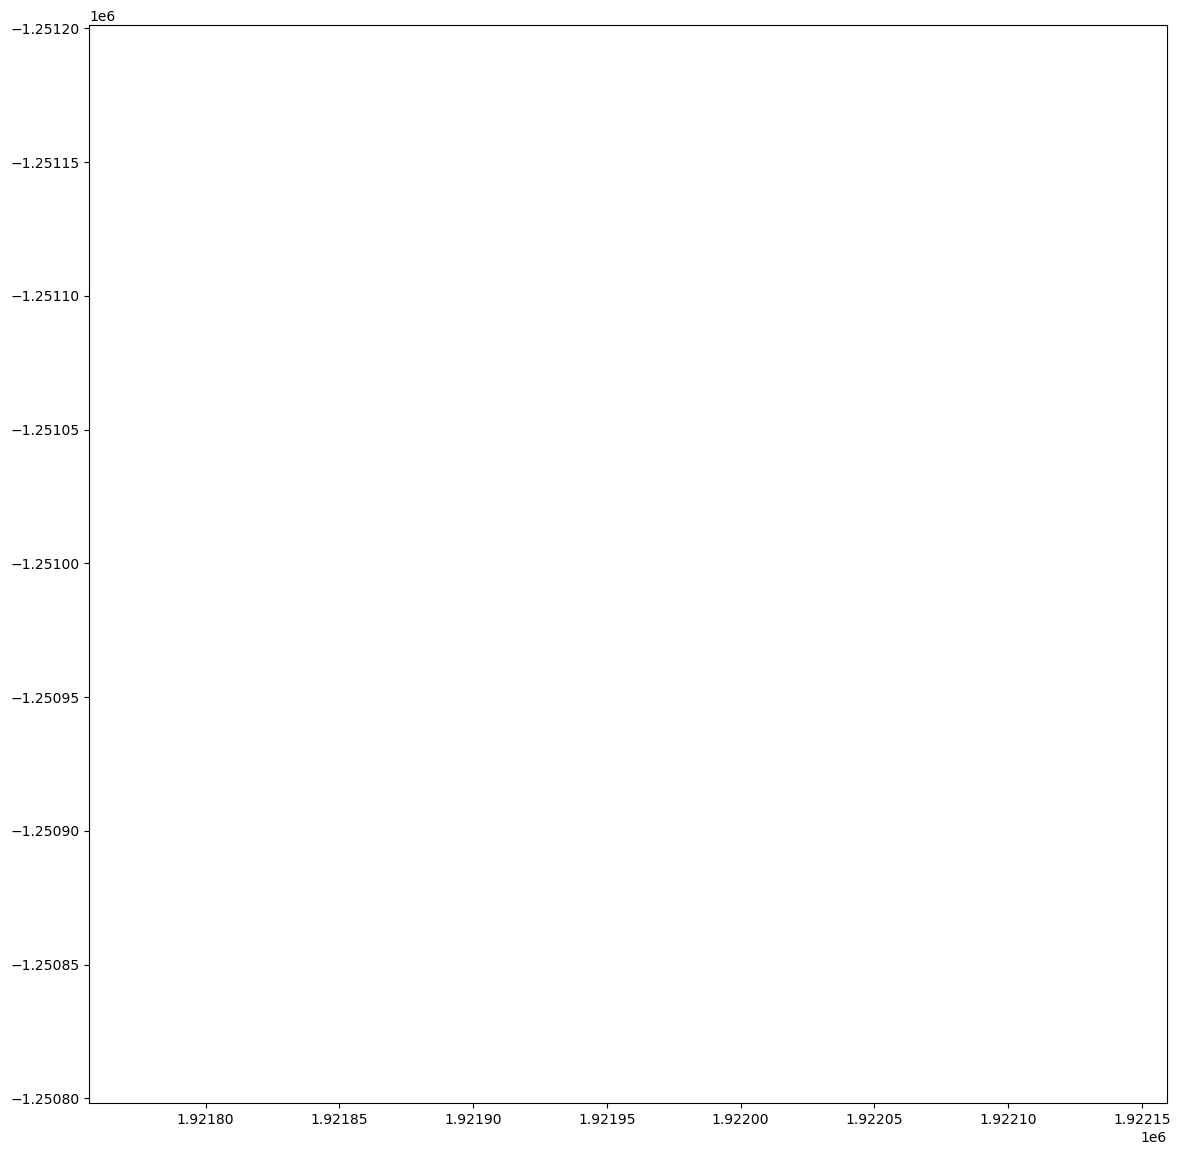

<Axes: >

In [12]:
plt.figure(figsize=(14,14))
src = rasterio.open("../station_config/output/a2021-05-20_US-UTW.tif")
show(src)

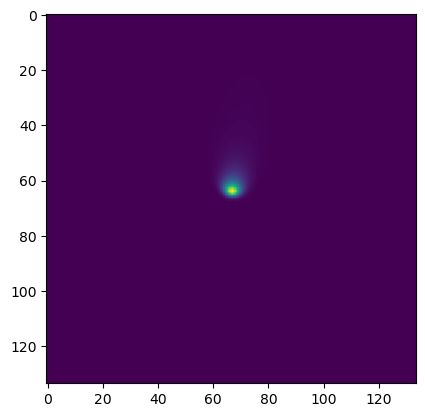

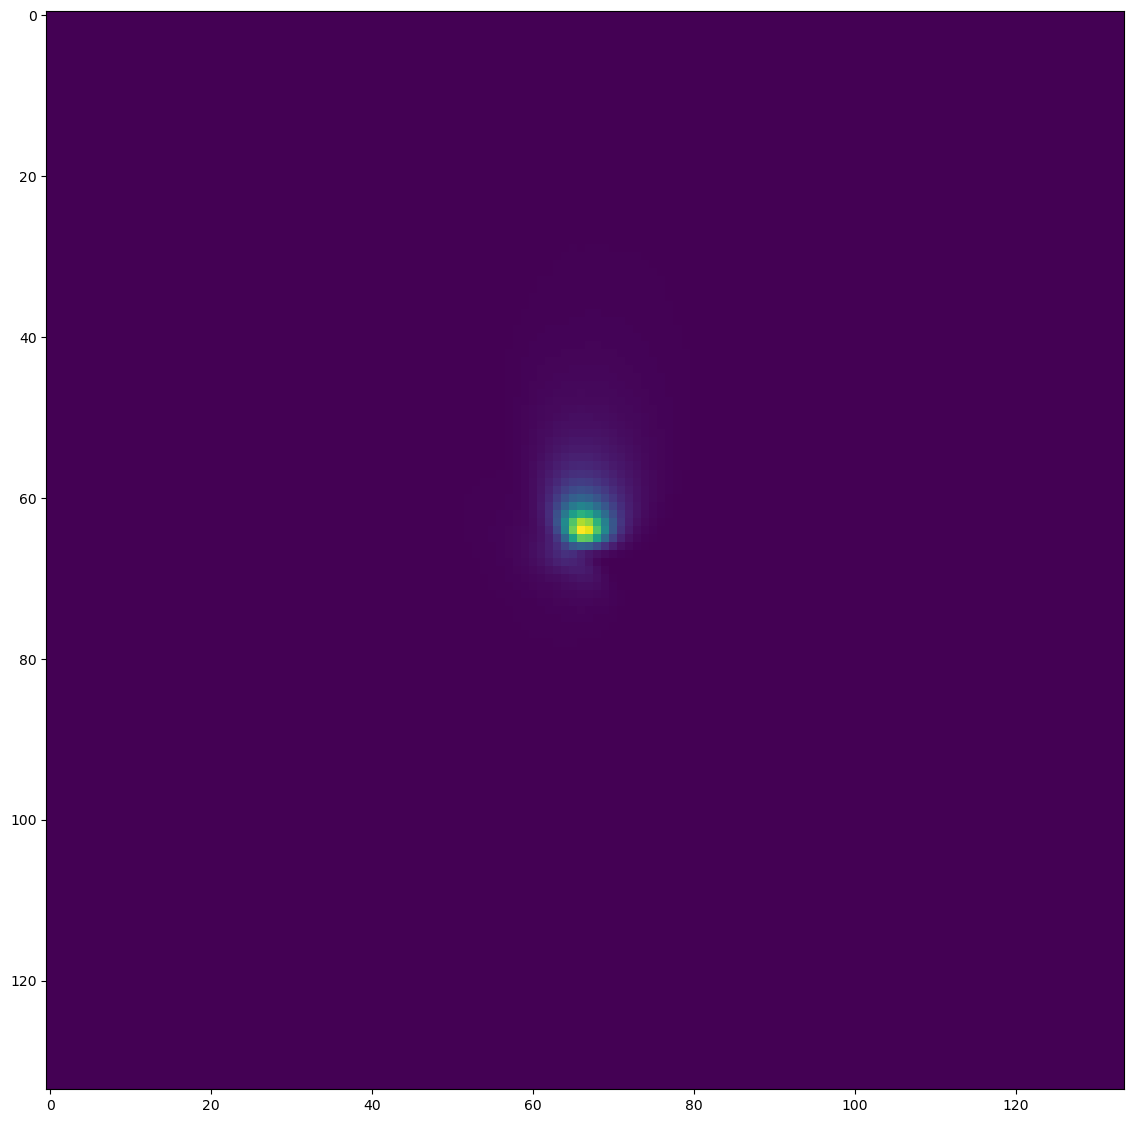

In [13]:
show(src.read(6))
# Daily average
arrs = []
cnt = 0
for i in range(1, 15):
    arr = src.read(i)
    if (arr == 0).all():
        continue
    else:
        cnt += 1
        arrs.append(arr)
avg_for_day = sum(arrs) / cnt

plt.figure(figsize=(14, 14))
plt.imshow(avg_for_day)